<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Прогнозирование-оттока-клиентов" data-toc-modified-id="Прогнозирование-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Прогнозирование оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Стратегия удержания клиентов в сети фитнес-центров

Поскольку отток клиентов является существенной проблемой для фитнес-клубов, необходимо иметь инструменты для прогнозирования оттока и выявления признаков, влияющих на отток.

В связи с этим **цель данного исследования** - научиться прогнозировать вероятность оттока сети фитнес-центров «Культурист-датасаентист» на уровне следующего месяца для каждого клиента.

Для достижения данной цели необходимо решить несколько **промежуточных задач**:
1. Обучить модель на данных предыдущих периодов.
2. Сформировать типичные портреты клиентов.
3. Проанализировать основные признаки, наиболее сильно влияющие на отток.
4. Разработать рекомендации по повышению качества работы с клиентами.

**Описание данных:**
* `gender` — пол
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр
* `Partner` — сотрудник компании-партнёра клуба
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»
* `Phone` — наличие контактного телефона
* `Age` — возраст
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)
* `Contract_period` — длительность текущего действующего абонемента
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
* `Group_visits` — факт посещения групповых занятий
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра
* `Churn` — факт оттока в текущем месяце

**Ход исследования:**
1. Обзор данных
2. EDA
3. Прогнозирование оттока клиентов
4. Кластеризация клиентов
5. Выводы

## Обзор данных

Загрузим необходимые для исследования библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from itertools import combinations
import phik
from phik.report import plot_correlation_matrix

%matplotlib inline

Прочитаем данные о посетителях фитес-клуба, выведем информацию о датафлейме и его первые пять строк:

In [2]:
gym = pd.read_csv('censored')
pd.set_option('display.max_columns', 50)

gym.info()
gym.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Как видно из полученных данных, в таблице представлена информация о 4000 наблюдений (в случае отсутствия дубликатов), пропусков нет. При этом в датафрейме присутствуют исключительно числовые столбцы, многие из который определяют бинарные факторы (например, `gender`, `Near_Location`, `Partner`, `Churn` и др.), т. е. принимают только значения 0 или 1. Всего имеется 13 признаков и целевая переменная - `Churn`.

В столбцах выбраны верные типы данных (вопросы вызывает только признак `Month_to_end_contract`, где, возможно, нужны только целые числа). Проверим это предположение, однако сначала приведём стиль заголовков к `snake_case` и проверим датафрейм на наличие дубликатов.

In [3]:
# меняем стиль заголовков:
gym.columns = gym.columns.str.lower()
display(gym.columns)

# проверяем наличие дубликатов:
gym.duplicated().sum()

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

0

Так, заголовки приведены к нижнему регистру, дубликаты проверены (их нет). Теперь посмотрим на значения столбца `month_to_end_contract`, чтобы понять, верный ли для него выбран тип данных:

In [4]:
gym['month_to_end_contract'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

Так, все значения данного признака целочисленные, значит, можно заменить тип данных в столбце с `float` на `int`:

In [5]:
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int')

gym['month_to_end_contract'].dtype

dtype('int64')

Отлично, можно приступать к исследовательскому анализу данных.

## EDA

Для начала посмотрим на средние значения и стандартные отклонения признаков: <a id='describe'></a>

In [6]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Из предварительного анализа показателей можно сделать следующие выводы:
* количество клиентов *мужского и женского пола примерно одинаково*;
* *проживают или работают в районе*, где находится фитнес-клуб, **84.5% клиентов**;
* *немногим меньше половины* клиентов являются *сотрудниками компаний-партнёров*, что даёт им скидки на абонемент;
* **30.9%** клиентов записались в фитнес-центр в рамках *акции «приведи друга»*;
* у фитнес-центра *есть телефоны большиства (более 90%) клиентов*;
* *длительность текущего абонемента в среднем составляет 4.68 месяцев*, при этом стандартное отклонение достаточно большое (4.6 месяцев) - действительно, минимальный срок абонемента составляет 1 месяц, причём на такой срок договоры заключают по крайней мере 50% клиентов, максимальный - 1 год;
* **чуть более 40%** клиентов посещают *групповые занятия*;
* *средний и медианный возраст* клиентов примерно совпадают и составляют **29 лет**, при этом возраст варьируется от 18 лет до 41 года;
* *средняя суммарная выручка с клиента от других услуг фитнес-клуба* составляет **146.94**, стандартное отклонение большое: разброс значений находится в границах от 0.15 до 552.59;
* *средний срок до окончания контракта составляет 4.32 месяца* (медианный - 1 месяц, видимо, поскольку месячных контрактов большинство);
* *средний лайфтайм клиента - 3.7 месяцев*, при этом стандартное отклонение огромное (равно среднему значению);
* *средняя частота посещений в неделю за все время с начала действия абонемента равна 1.9 раз* (примерно равна медианной), величина колеблется от 0 до 6;
* *средняя частота посещений в неделю за предыдущий месяц составляет 1.77*, при этом *стандартное отклонение здесь выше*, чем в предыдущем случае;
* в среднем **26.53%** клиентов *не возвращаются в фитнес-клуб*.

Сгруппируем датафрейм по значениям целевой переменной `churn`: <a id='bars'></a>

In [7]:
gym_churn = gym.groupby('churn').agg('mean').reset_index()

gym_churn

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


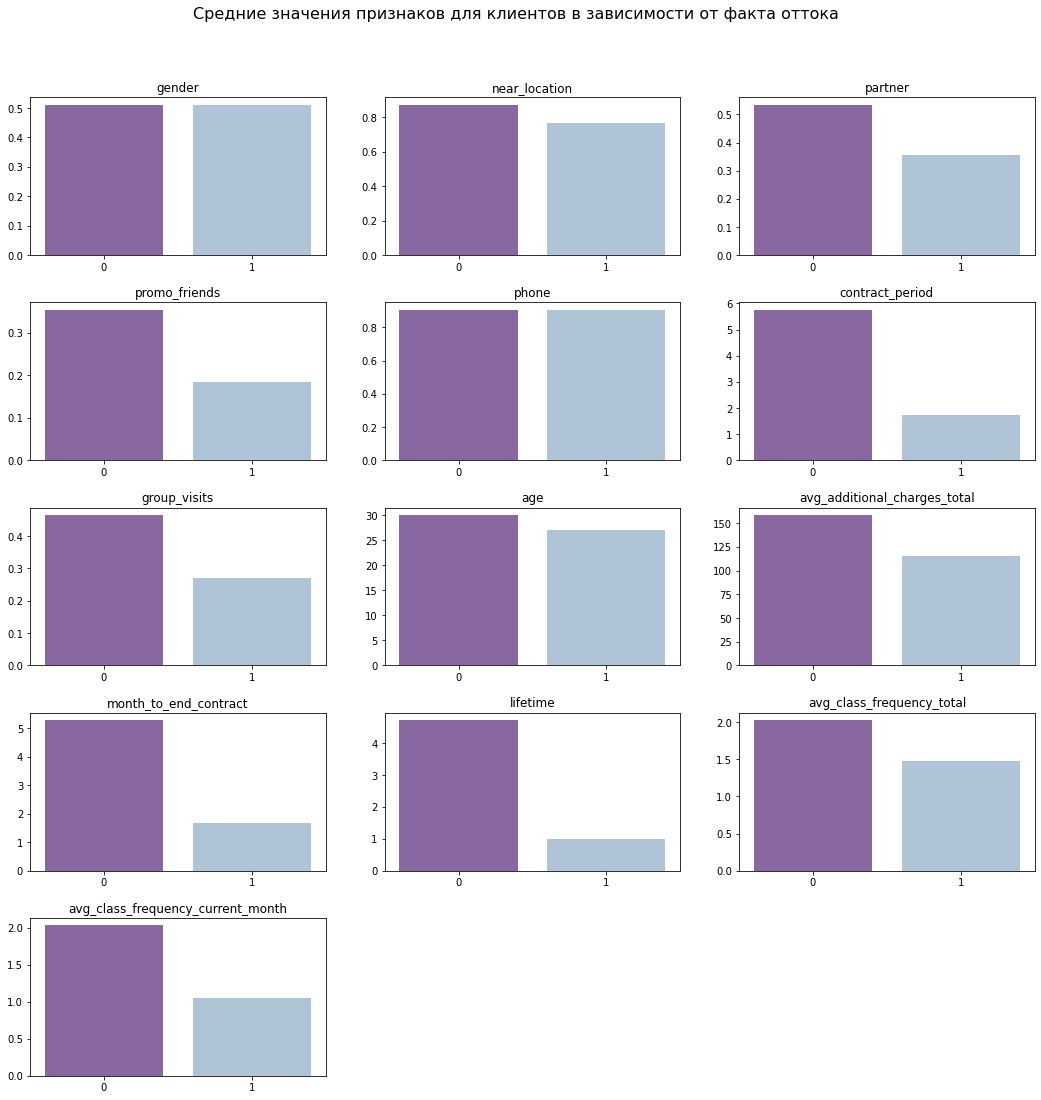

In [8]:
# визуализируем:
fig, axes = plt.subplots(5, 3)
fig.suptitle('Средние значения признаков для клиентов в зависимости от факта оттока', fontsize=16, y=0.95)
for index, value in enumerate(gym_churn.columns[1:]):
    ax = plt.subplot(5, 3, index+1)
    sns.barplot(x='churn', y=value, data=gym_churn, palette=sns.color_palette('BuPu_r', 2))
    plt.xlabel('')
    plt.ylabel('')
    plt.title(value)
fig.set_figheight(18)
fig.set_figwidth(18)
plt.subplots_adjust(hspace=0.3)
fig.delaxes(axes[4][1])
fig.delaxes(axes[4][2])
plt.show()

Столбчатые диаграммы показывают, что:
* у клиентов, которые ушли в отток и которые остались, *не наблюдается различий по полу и наличию информации о телефоне*;
* между данными группами есть *некоторые различия в расположении фитнес-клуба относительно жилья / работы клиента* (у тех, кто ушёл в отток, он на 10 п. п. реже находится поблизости), *в среднем возрасте клиентов* (клиенты, уходящие в отток, в среднем моложе - 27 против 30 лет), *в средней суммарной выручке от других услуг фитнес-центра* (у тех, кто выходит в отток, она в среднем ниже на 43, значит, они реже пользуются дополнительными услугами);
* *различия по всем остальным факторам существенны*, причем меньшие значения всегда встречаются у группы оттока: наиболее значительная разница наблюдается по таким признакам, как лайфтайм (меньше месяца против 4.7 месяца), количества месяцев до конца контракта (1.7 против 5.3), срок контракта (1.7 месяца против 5.7 месяца).

Таким образом, **клиенты, которые меньше по времени взаимодействуют с финтес-клубом более склонны к оттоку**, что логично.

Построим столбчатые гистограммы распредления, исходя из признака оттока: <a id='hist'></a>

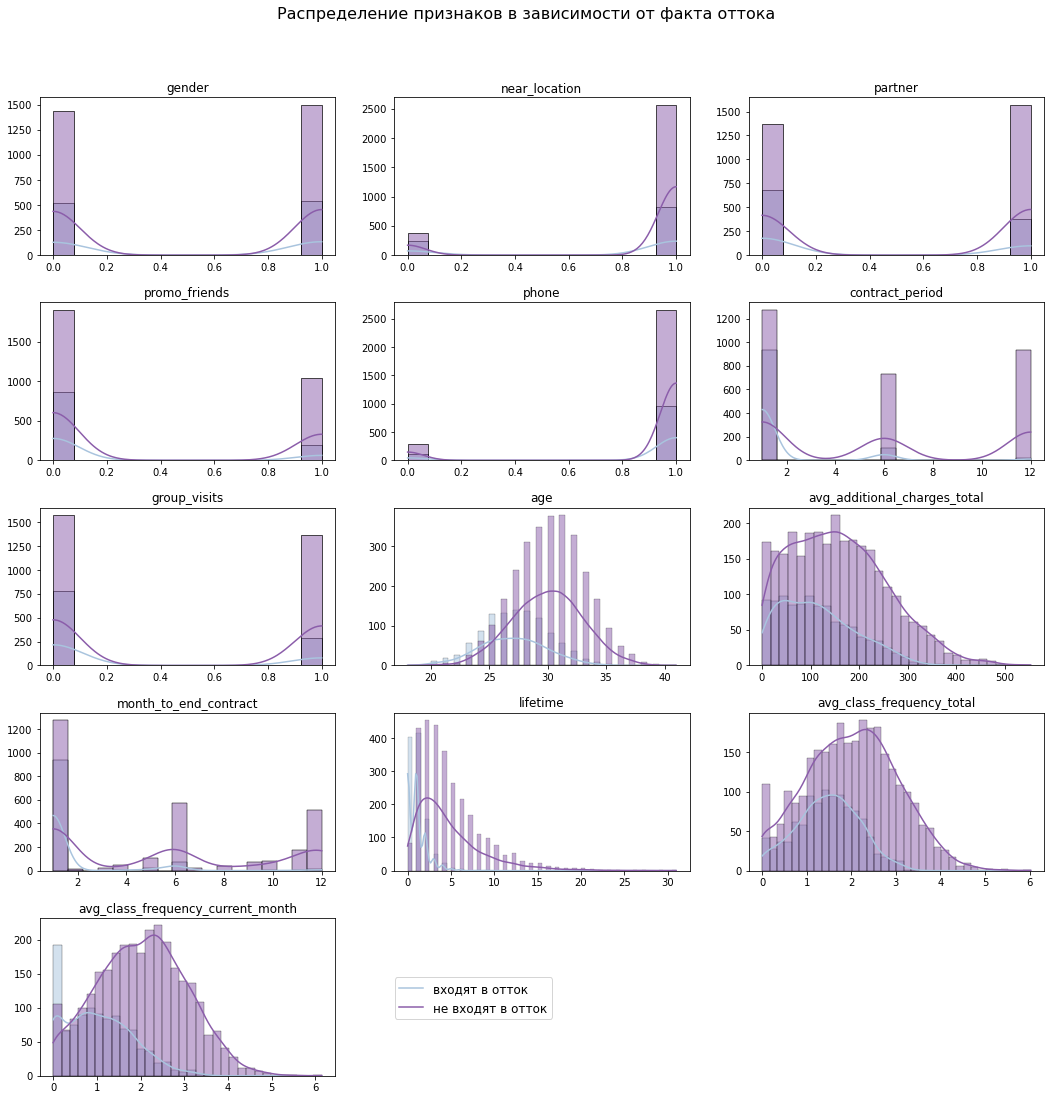

In [9]:
fig, axes = plt.subplots(5, 3)
fig.suptitle('Распределение признаков в зависимости от факта оттока', fontsize=16, y=0.95)
for index, value in enumerate(gym.columns[:13]):
    ax = plt.subplot(5, 3, index+1)
    sns.histplot(data=gym, x=value, hue='churn', kde=True, palette=sns.color_palette('BuPu_r', 2), legend=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(value)
fig.set_figheight(18)
fig.set_figwidth(18)
plt.subplots_adjust(hspace=0.3)
fig.delaxes(axes[4][1])
fig.delaxes(axes[4][2])
fig.legend(['входят в отток', 'не входят в отток'], loc='center right', bbox_to_anchor=(0.525, 0.185), fontsize=12, frameon=True)
plt.show()

В целом, гистограммы вторят столбчатым диаграммам: **клиенты, попавшие в отток гораздо меньше взаимодействовали с фитнес-клубом как по сроку, так и по объёму используемых услуг**. Кроме того, возраст таких клиентов варьируется от 18 до 35 и они значительно реже приходят в рамках акции «приведи друга».

Теперь изучим корреляцию признаков между собой и с целевой переменной. Для этого построим матрицу корреляций: <a id='corr'></a>

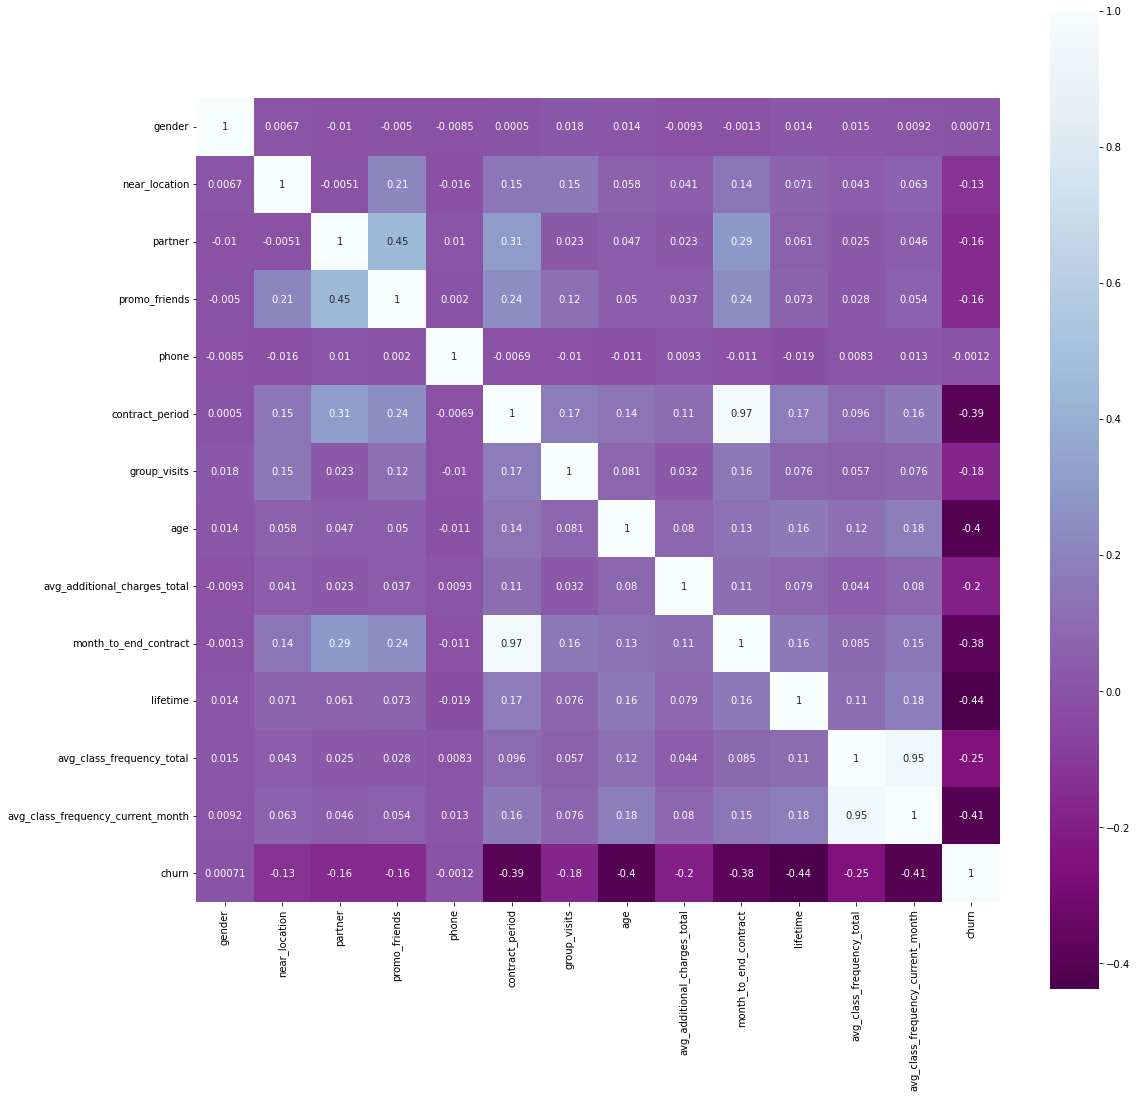

In [10]:
cm = gym.corr()

# визуализируем:
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(cm, annot=True, square=True, cmap='BuPu_r', annot_kws={"size": 10})
plt.show()

Так, сильная корреляция между признаками встречается в двух случаях:
1. между признаками `month_to_end_contract` и `contract_period` (коэффициент корреляции = 0.97), что логично, ведь общая продолжительность контракта непосредственно влияет на количество месяцев, которые могут остаться до его завершения;
2. между признаками `avg_class_frequency_total` и `avg_class_frequency_current_month` (коэффициент корреляции = 0.95), что может говорить о том, что частота посещений спортзала редко существенно меняется от месяца к месяцу, даже если этот месяц предшествует уходу клиента из фитнес-клуба (кроме того, это может указывать на то, что для многих клиентов, попавших в отток, первый месяц посещения фитнес-клуба стал последним, т. е. `avg_class_frequency_total` и `avg_class_frequency_current_month` для них совпадают).

В остальном признаки не коррелируют между собой. Исключения составляют разве что пары `promo_friends` - `partner` и `contract_period` - `partner`, однако связь достаточно слабая.

Что касается корреляции признаков с целевой переменной, то со всеми признаками, кроме пола, наблюдается слабая отрицательная корреляция. Наиболее сильно целевая переменная коррелирует с лайфтаймом клиента, средней частотой посещений в неделю за предыдущий месяц, возрастом и сроком абонемента / количеством месяцев до конца абонемента.

Поскольку в таблице много категориальных признаков, надо учитывать также наличие неоинейной корреляции. Построим матрицу корреляций с помощью библиотеки `phik`:

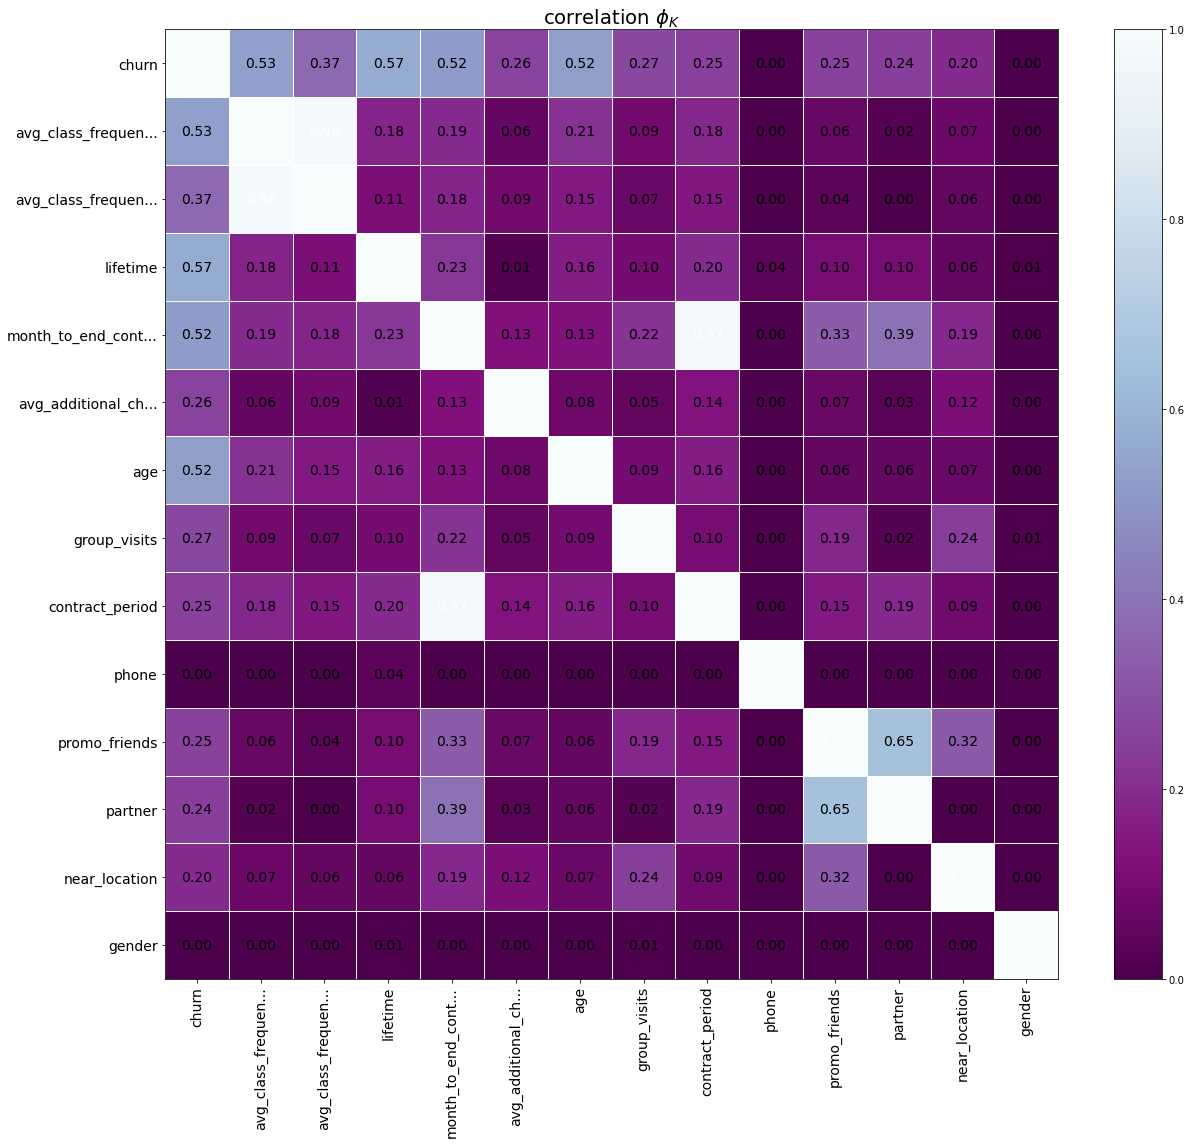

In [11]:
interval_cols = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
phik_overview = gym.phik_matrix(interval_cols=interval_cols)

# визуализируем:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='BuPu_r', 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.4, 
                        figsize=(18, 16))
plt.tight_layout()
plt.show()

В целом выводы подтвердлились. Здесб надлюдается также корреляция между переменными `partner` и `promo_friends`, но её значение не очень велико.

Удалим по одному из пар сильно коррелирующих признаков (будем удалять тот, что меньше коррелирует с зависимой переменной):

In [12]:
gym.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1, inplace=True)

# проверяем:
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0


Отлично, мы избавились от сильно скоррелированных признаков.

Таким образом, мы получили [предсталение об общих характеристиках всех клиентов фитнес-клуба](#describe) и [о том, как эти характеристики различаются в заивисмости от факта оттока](#bars), сделав вывод, что средние значения всех признаков, кроме пола и наличия информации о телефоне, у клиентов, попавших в отток, ниже (или ниже вероятность того, что признак есть). Кроме того, были удалены [сильно скоррелированные признаки](#corr) (их осталось 11). Корреляция признаков с целевой переменной в основном отрицательная.

Приступим к построению модели.

## Прогнозирование оттока клиентов

Для прогнозирования оттока клиентов в следующем месяце построим модель бинарной классификации. Для этого сначала разобьём выборку на обучающую и валидационную и стандартизируем данные:

In [13]:
# разбиваем выборку на признаки и целевую переменную:
X = gym.drop('churn', axis=1)
y = gym['churn']

# разделяем выборку на обучаяющую и валидационную:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# проверим размеры выборок:
display('Размер X_train: {}%, размер X_test: {}%, размер y_train: {}%, размер y_test: {}%'.format(
    round(len(X_train) / len(X) * 100, 2),
    round(len(X_test) / len(X) * 100, 2),
    round(len(y_train) / len(y) * 100, 2),
    round(len(y_test) / len(y) * 100, 2)
))

# стандартизируем данные:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

'Размер X_train: 80.0%, размер X_test: 20.0%, размер y_train: 80.0%, размер y_test: 20.0%'

Обучим две модели бинарной классификации - логистическую регрессию и случайный лес - и сравним их метрики accuracy, precision и recall на валидационной выборке:

In [14]:
# формируем список моделей:
models = [LogisticRegression(solver='liblinear', random_state=0), RandomForestClassifier(random_state=0)]

# пишем функцию для обучения модели и расчёта метрик:
def make_forecast(m, X_train, X_test, y_train, y_test):
    model = m
    model.fit(X_train, y_train)
    
    # делаем прогноз:
    y_pred = model.predict(X_test)
    
    # ищем вероятность того, что клиент попадёт в отток:
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # считаем метрики:
    display('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f} ROC_AUC: {:.2f}'.format(
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    ))

# пишем цикл:
for m in models:
    display(m)
    make_forecast(m, X_train_st, X_test_st, y_train, y_test)

LogisticRegression(random_state=0, solver='liblinear')

'Accuracy: 0.90 Precision: 0.79 Recall: 0.82 ROC_AUC: 0.96'

RandomForestClassifier(random_state=0)

'Accuracy: 0.90 Precision: 0.81 Recall: 0.75 ROC_AUC: 0.95'

В целом значения метрик моделей очень похожи, однако небольшие различия всё же есть:
* Доля правильных равна для обеих моделей, однако данной метрике не стоит сильно доверять, поскольку в нашем случае, судя [по соотношению значений `churn` по всей выборке](#hist), вряд ли соблюдается баланс классов. Следовательно, необходимо проверить это дополнительно для `y_test`.
* Точность на две сотые выше у модели случайного леса: 81% клиентов, записанных данной моделью в отток, реально туда попали.
* Полнота на семь сотых выше для логистической регрессии, т. е. выявление клиентов, попавших в отток, выше у первой модели.
* Площадь под кривой ошибок также немного выше у логистической регресии.

In [15]:
# проверим соблюдение баланса классов:
display('Вся выборка')
display(y.value_counts())

display('Валидационная выборка')
y_test.value_counts()

'Вся выборка'

0    2939
1    1061
Name: churn, dtype: int64

'Валидационная выборка'

0    602
1    198
Name: churn, dtype: int64

Как и следовало ожидать, баланс классов не соблюдается, причём на валидационной выборке соотношение между 0 и 1 ещё более неравнозначное, так что доверять критерию accuracy всё-таки не стоит. Однако в целом это не меняет выводов, поскольку данная метрика равно для обеих моделей.

Что касается метрики, на которую надо опираться, то в данном случае это скорее recall, поскольку, если для лояльных и потенциально лояльных клиентов фитнес-клуб, готов делать скидки, подарки и прочие программы лояльности, то надо уметь выявлять нелояльных клиентов, чтобы не тратить на них ресурсы. Так, **логистическая регрессия показала лучшие результаты по результатам оценки критериев**, а значит, использовать следует именно её.

## Кластеризация клиентов

Чтобы выявить несколько групп клиентов со сходными характеристиками, проведём процесс кластеризации.

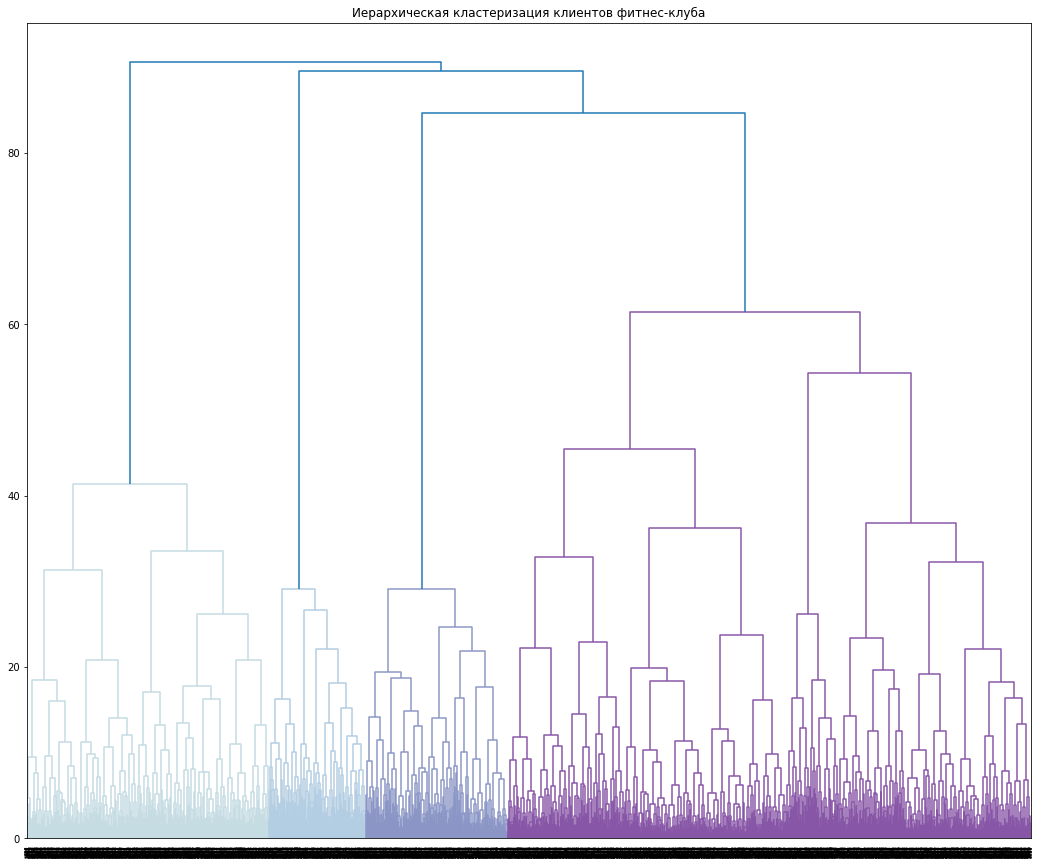

In [16]:
# стандартизируем данные:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

# строим матрицу расстояний:
dist_matrix = linkage(x_sc, method='ward')

# нарисуем дендрограмму:
plt.figure(figsize=(18, 15))
set_link_color_palette(['#c4dce2', '#b3cde3', '#8c96c6', '#8856a7', '#810f7c'])
dendrogram(dist_matrix, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-клуба')
plt.show()

Оптимальным кажется расстояние объетами, равное примерно 57-60, так кластеры кажутся наиболее равномерными, т. е. K = 5.

Используем алгоритм K-Means для прогнозирования кластеров клиентов:

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


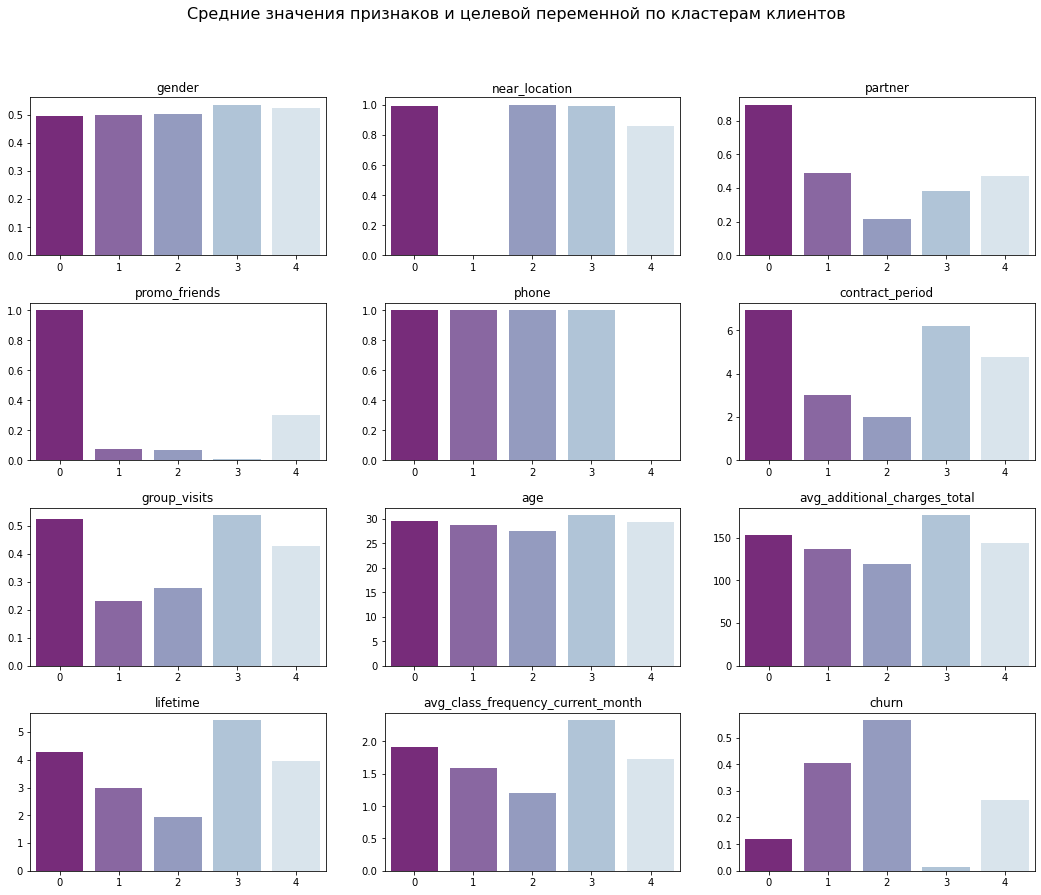

In [17]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)

# сохраняем метки кластеров в таблицу:
gym['cluster_km'] = labels

# посмотрим на среднее значение признаков для кластеров:
clusters_mean = gym.groupby('cluster_km').agg({
    i : 'mean' for i in gym.drop('cluster_km', axis=1).columns}).reset_index().sort_values(by='cluster_km')

# выведем таблицу:
display(clusters_mean)

# визуализируем:
fig, axes = plt.subplots(4, 3)
fig.suptitle('Средние значения признаков и целевой переменной по кластерам клиентов', fontsize=16, y=0.95)
for index, value in enumerate(clusters_mean.columns[1:]):
    ax = plt.subplot(5, 3, index+1)
    sns.barplot(x='cluster_km', y=value, data=clusters_mean, palette=sns.color_palette('BuPu_r', 5))
    plt.xlabel('')
    plt.ylabel('')
    plt.title(value)
fig.set_figheight(18)
fig.set_figwidth(18)
plt.subplots_adjust(hspace=0.3)
plt.show()

Так, сразу можно выделить несколько закономерностей:
* *Доля оттока клиентов наиболее велика в кластерах 2 и 1* и составляет **56.4%** и **40.3%** соответственно. *Самая низкая доля оттока у кластера 3* (**1.5%**), за ним следует *кластер 0* (**26.7%**).
* Все клиенты кластера 0 (одного из кластеров с наименьшим оттоком) пришли в рамках акции "приведи друга". Также среди них несравнимо чаще встречаются сотрудники компаний-партнёров клуба (89.2% клиентов). Можно сказать, что данная группа представляет из себя тех клиентов, которым по соображениям предоставляемых скидок выгодно ходить именно в эту сеть фитнес-клубов.
* Кластер 3 (с наименьшим оттоком) представлен наиболее лояльными клиентами: у них самый высокий лайфтайм и средние суммарные траты на другие услуги фитнес-клуба.
* В обоих кластерах с самым низким оттоком наибольшее количество клиентов (больше половины в каждом кластере) посещают групповые занятия и самые длительные сроки абонемента.
* У клиентов кластеров 2 и 1 (с наибольшим оттоком) наименьший средний срок абонемента и лайфтайма, а также наименьшая доля из них посещает групповые занятия (27.7% и 23.3% соответственно). Помимо того, только по 7% из клиентов даных кластеров пришли в фитнес-клуб в рамках акции "привели друга".
* Никто из клиентов кластера 1 не живёт и не работает в районе, где расположен фитнес-клуб.

Таким образом, клиентов, склонных и не склонных к оттоку, можно поделить на категории:
* не склонные к оттоку:
    * клиенты, пришедшие в спортзал в рамках акции;
    * лояльные клиенты, взаимодействующее с фитнес-центром продолжительное время и пользующиеся дополнительными услугами;
* склонные к оттоку:
    * клиенты, уходящие по причине неудобного расположения фитнес-клуба;
    * клиенты с коротким лайфтаймом, уходящие по прочим причинам.

Посмотрим на распределение признаков для кластеров:

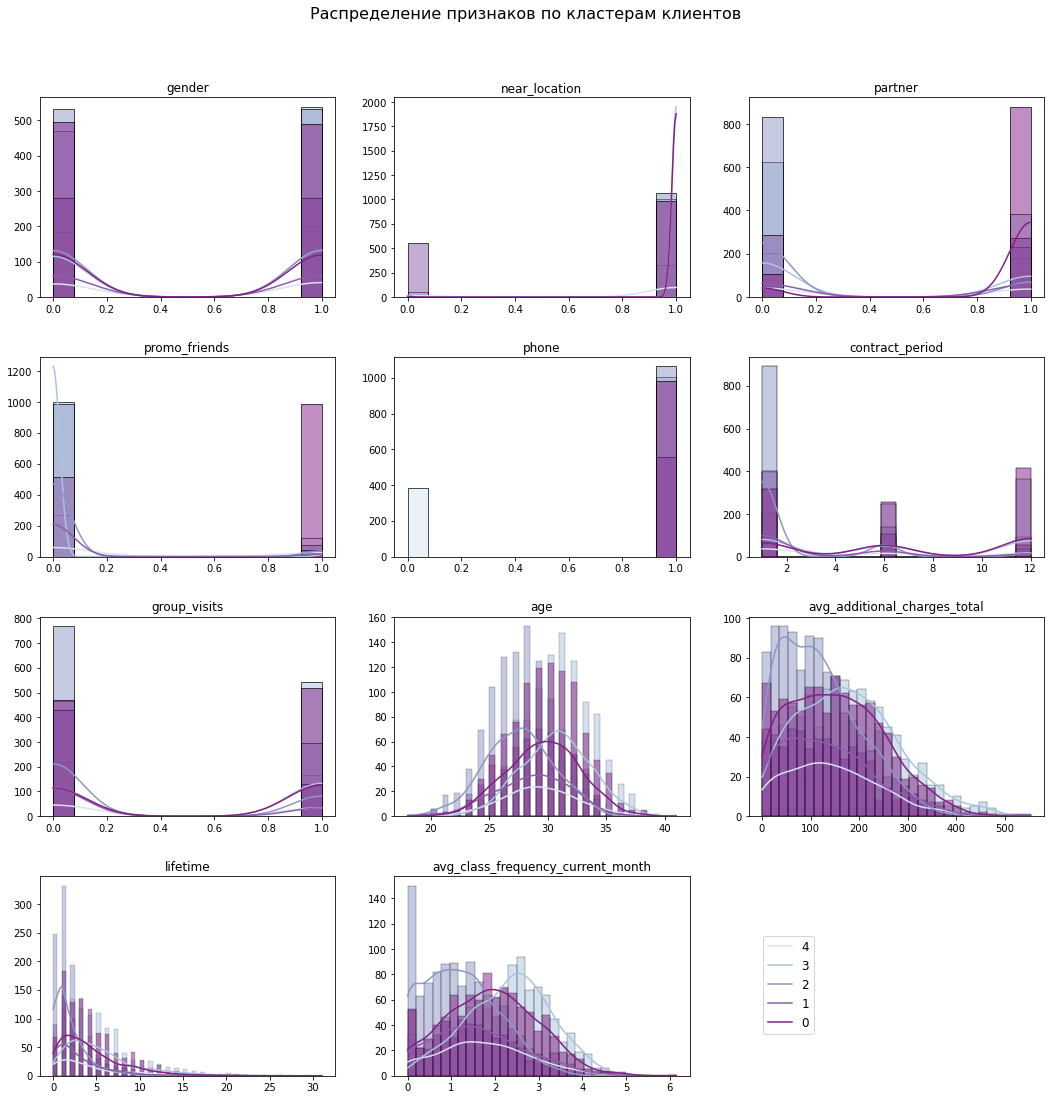

In [18]:
fig, axes = plt.subplots(4, 3)
fig.suptitle('Распределение признаков по кластерам клиентов', fontsize=16, y=0.95)
for index, value in enumerate(gym.columns[:11]):
    ax = plt.subplot(4, 3, index+1)
    sns.histplot(data=gym, x=value, hue='cluster_km', kde=True, palette=sns.color_palette('BuPu_r', 5), legend=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(value)
fig.set_figheight(18)
fig.set_figwidth(18)
plt.subplots_adjust(hspace=0.3)
fig.delaxes(axes[3][2])
fig.legend([4, 3, 2, 1, 0], loc='center right', bbox_to_anchor=(0.727, 0.195), fontsize=12, frameon=True)
plt.show()

Графики распределения подтвердают уже сделанные выводы. Кроме того, видно, что кластеры не равны по размеру. Кажется, что наиболее многочисленным является кластер 2, наименее многочисленным - кластер 4. Проверим это предположение: <a id='clusters'></a>

In [19]:
gym['cluster_km'].value_counts().sort_values()

4     386
1     558
0     985
3    1007
2    1064
Name: cluster_km, dtype: int64

Гипотеза подтвердилась. Надо сказать, что такое распределение не является выгодным для фитнес-клуба, поскольку в кластере 2 наблюдается значительный отток клиентов.

Построим графики попарного сочетания признаков, чтобы поточнее посмотреть, насколько кластеры пересекаются между собой:

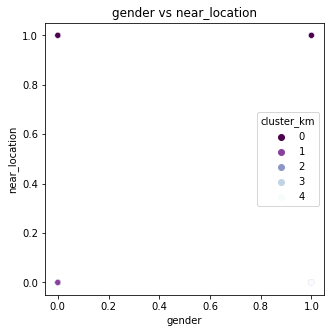

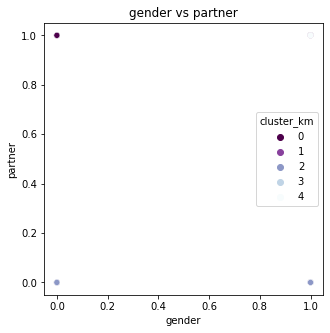

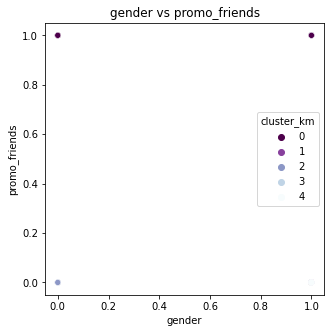

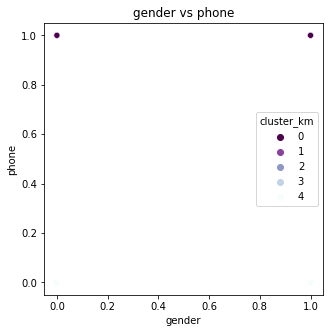

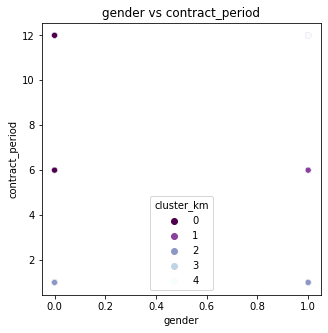

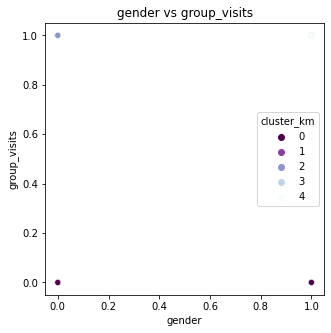

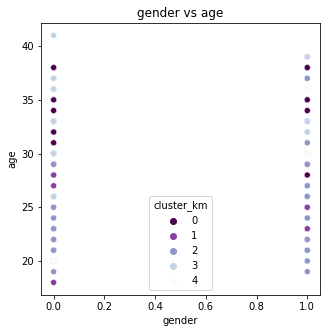

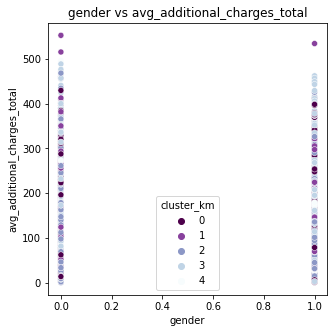

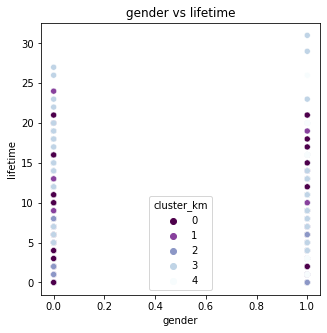

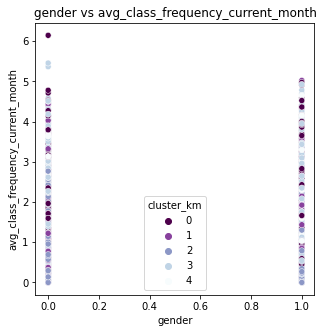

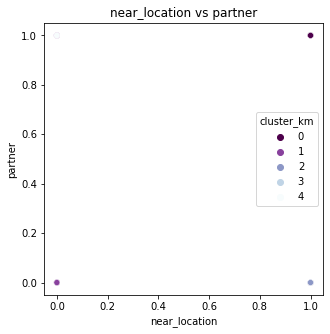

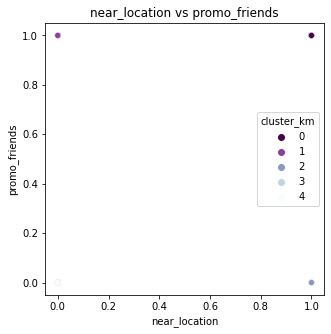

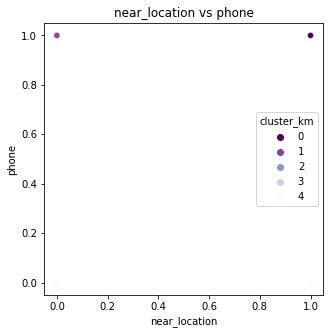

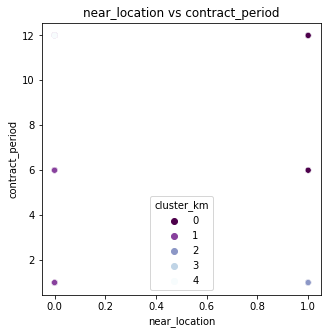

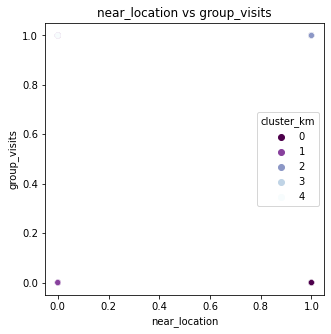

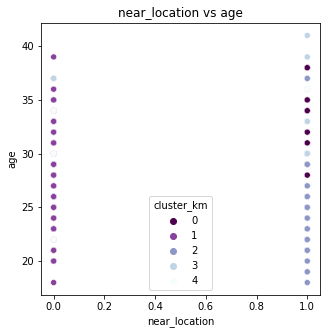

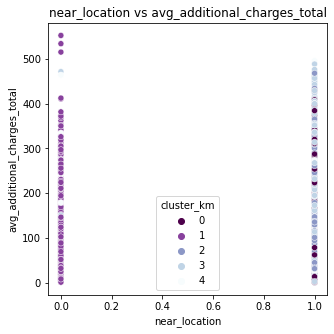

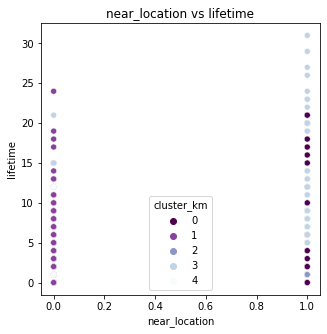

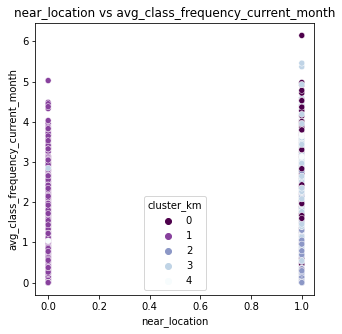

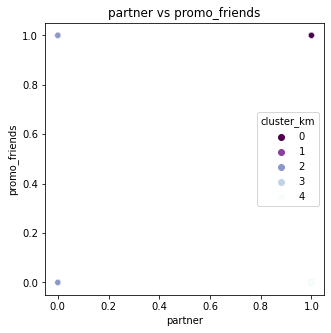

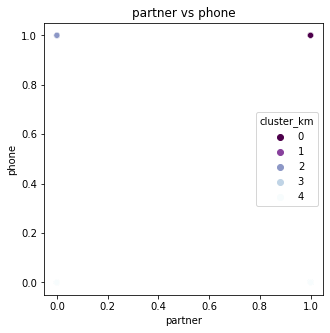

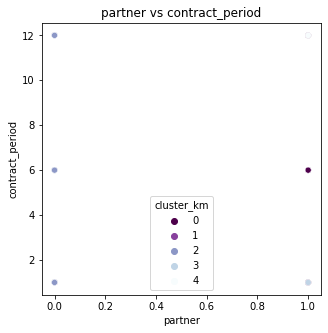

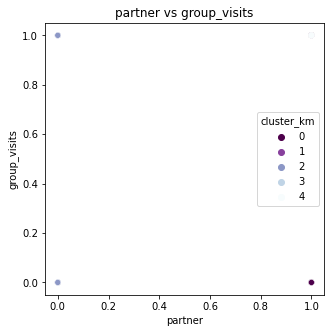

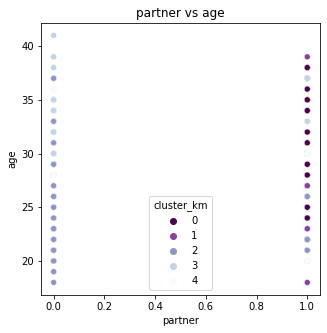

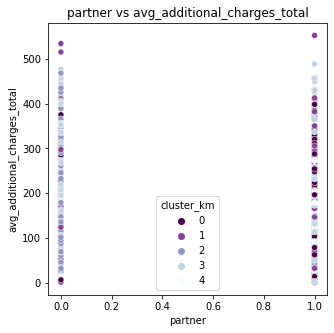

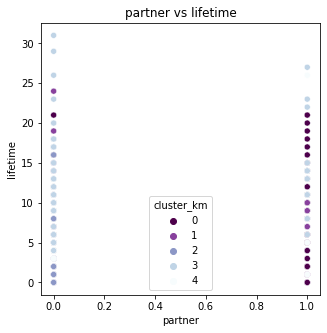

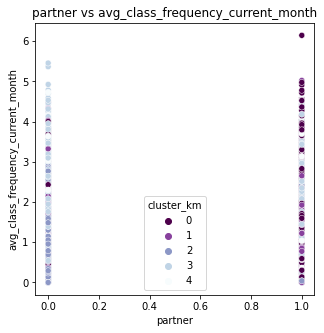

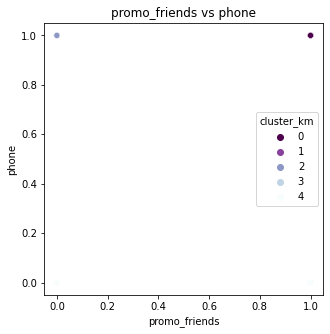

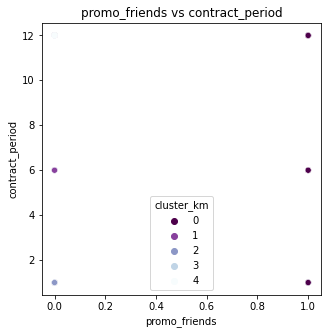

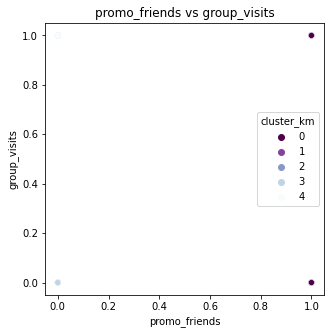

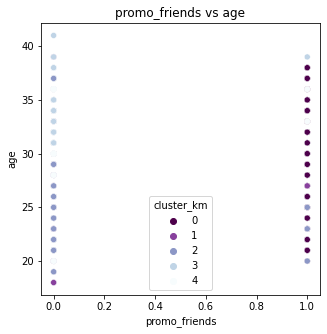

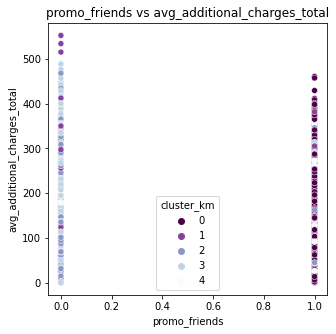

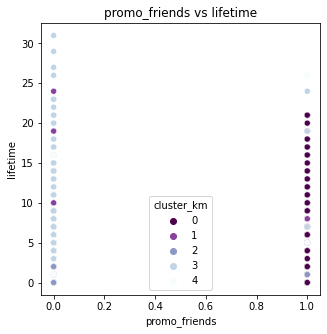

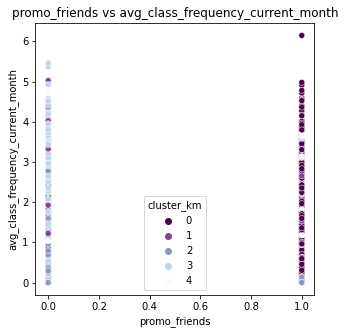

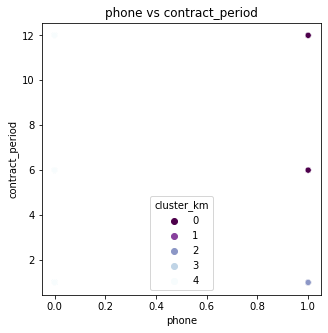

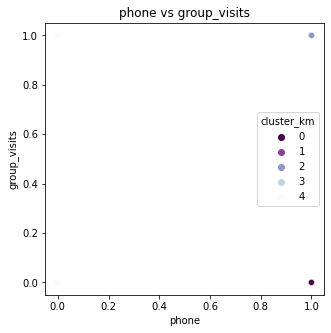

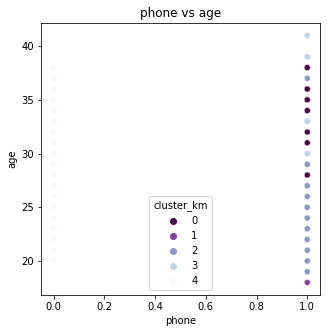

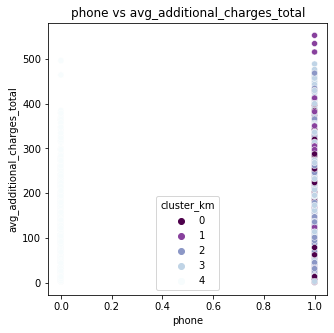

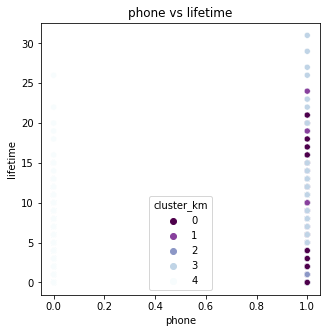

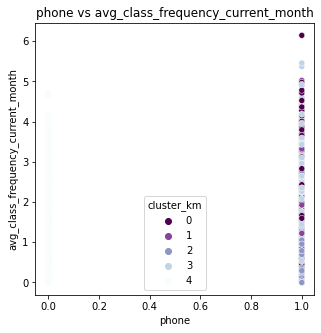

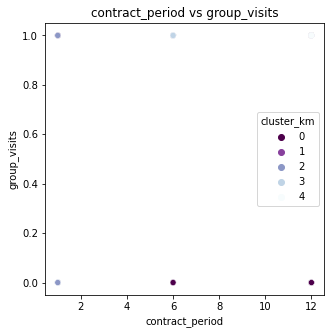

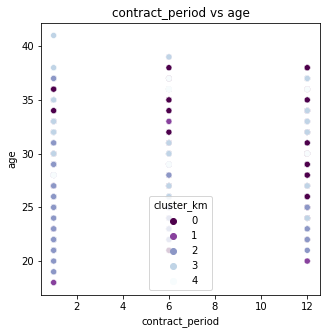

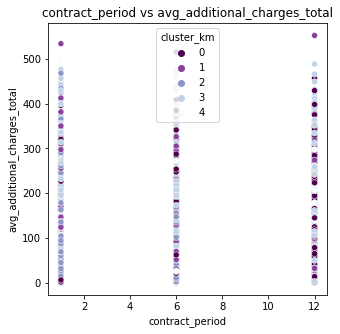

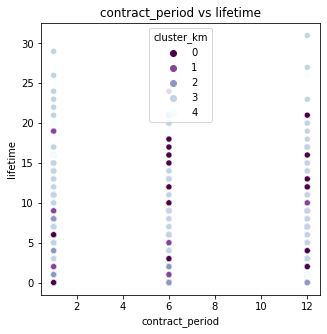

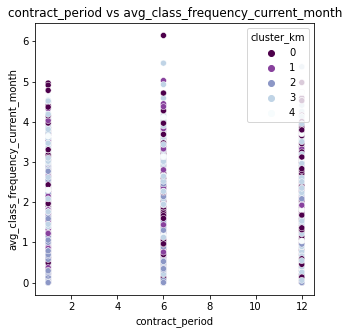

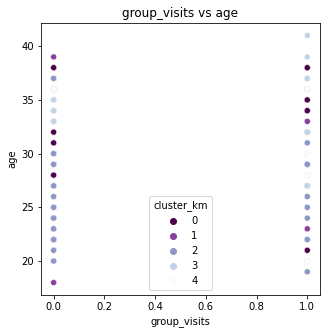

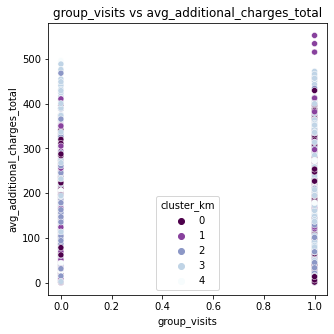

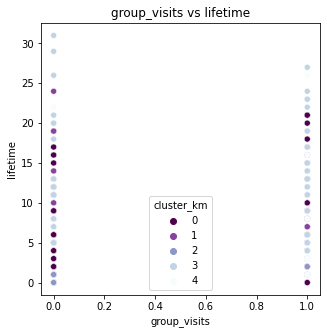

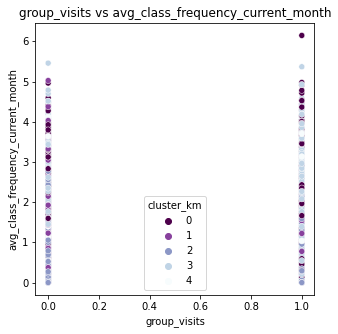

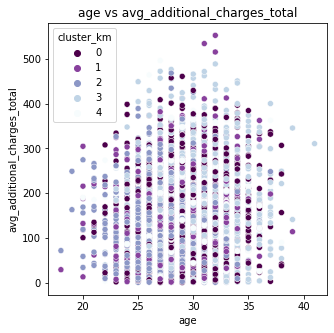

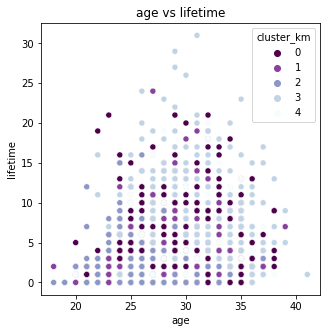

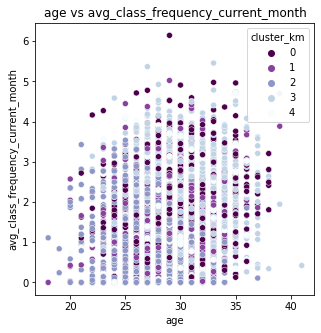

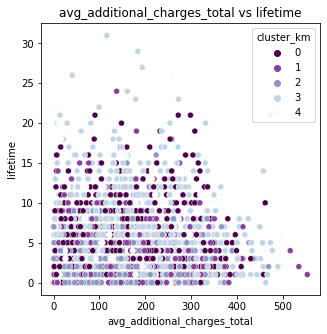

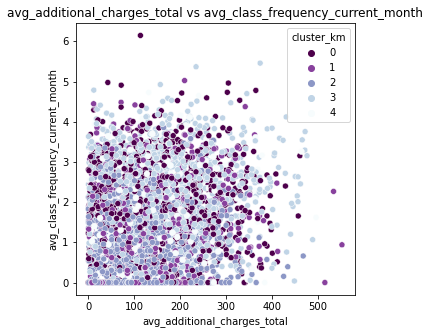

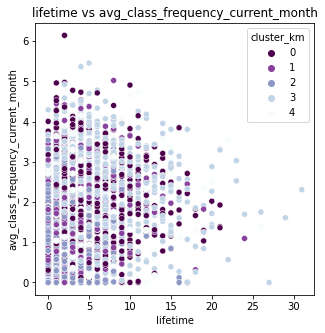

In [20]:
def cluster_vs_cluster(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='BuPu_r'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
    
col_pairs = list(combinations(gym.drop(['churn', 'cluster_km'], axis=1), 2))
for pair in col_pairs:
    cluster_vs_cluster(df=gym, x_name=pair[0], y_name=pair[1], cluster_name='cluster_km')

Так, по данным графикам явно выделяются три кластера: более плотно группируются кластеры 2, 3, также заметна группировна кластера 0.

Таким образом, можно сделать несколько выжных выводов:
* наличие дополнительных скидок и привилегий положительно влияет на лояльность клиентов;
* посещение групповых занятий и долгосрочные абонементы также удерживают клиентов в фитнес-клубе;
* далёкое расположение фитнес-клуба от мест жительства и работы увеличивает риск оттока;
* поскольку [кластер 2 с высокой долей оттока самый многочисленный](#clusters), надо попытаться увеличить лояльность впервую очередь именно среди клиентов этого кластера (клиенты с коротким лайфтаймом, уходящие по прочим причинам).

## Выводы

Для полученного датафрейма особой предобрадотки не понадобилось: отсутствуют пропуски и дубликаты. В рамках предобработки были выполнены только следующие действия: 1) все заголовки были приведены к `snake_case`, 2) тип данных в столбце `month_to_end_contract` был изменён с `float` на `int`.

В ходе исследовательского анализа данных было выявлено, что *клиенты, попавшие в отток гораздо меньше взаимодействовали с фитнес-клубом как по сроку, так и по объёму используемых услуг*. Кроме того, выяснилось, что между целевой переменной и всеми признаками, кроме возраста, *корреляция отрицательная*. Помимо этого, были удалены два признака, сильно скоррелированных с другими. В итоге **в датафрейме остались 11 признаков и целевая переменная**.

Для прогнозирования оттока клиентов в следующем месяце было построено две модели - логистическая регрессия и случайный лес. Они сранивались по метрикам accuracy, precision, recall и roc auc, приоритет среди которых отдавался полноте. **Выбор был сделан в пользу логистической регрессии.**

С помощью алгоритма K-Means клиенты были разбиты на **5 кластеров**, в двух из которых отток был минимален, а в двух других - достигал 40-56% (пятый кластер, видимо, был выделен для клиентов, которые не указали свой телефон). На основе изучения кластеров, было выяснено какие клиенты склонны, а какие не склонны к оттоку:
1. **Не склонными к оттоку** можно считать тех, кто:
    * пришли в фитнес-центр *в рамках акции*;
    * уже *долго* ходит в фитнес-клуб и активно пользуется *прочими услугами*.


2. **Склонные к оттоку** - это:
    * клиенты, уходящие по причине *неудобного расположения фитнес-клуба*;
    * клиенты *с коротким лайфтаймом*, уходящие по прочим причинам (поскольку данный кластер самый многочисленный, надо повышать удержание именно для таких клиентов).

Так, исходя из полученной информации, можно предложить **следующие действия по повышению удержания клиентов**:
1. Предоставление значительных *скидок на долгосрочный абонемент* новым клиентам или предоставление в *подарок нескольких групповых занятий*.
2. Повышение лояльности путём *единоразового предоставления новым клиентам в подарок какой-либо прочей услуги фитнес-центра* (массаж, косметическая процедура и др.).
3. *Небольшое снижение цены абонемента при повторных покупках* (до определённого момента, например, первые три раза).
4. Реализация *бонусных программ для лояльных посетителей* (например, сделать каждый 10 кофе в кафе бесплатным, дарить скидку на массаж или посещение сауны после покупки n-ого абонемента или абонемента на год).
5. Чтобы посетители не уходили в отток из-за неудобного для них расположения фитнес-центра, можно добавить функцию *использования абонемента в любом фитнес-клубе сети* (если она до сих пор не реализуется) и *информировать клиентов о наличии фитнес-клубов в удобных для него районах*.
6. Если видно, что средняя недельная *посещаемость клиентом спортзала за последний месяц сильно упала*, можно предложить ему посетить какую-нибудь процедуру (желательно опираться на прошлый опыт, если он что-то уже посещал) *со скидкой*.

Конечно, все эти рекомендации надо также проверить на предмет прибыльности для сети.